In [11]:
from google.colab import files
uploaded = files.upload()


Saving energy_storage_dataset.csv to energy_storage_dataset.csv


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('energy_storage_dataset.csv')  # replace with actual file name

# Display first few rows to check
df.head()


,Battery_SOC,Power_Demand,Renewable_Generation,Energy_Price,Action
0,48,42.314058,41.625480,0.201132,2
1,69,47.002044,2.947895,0.218158,2
2,38,24.186993,3.417256,0.059126,2
3,33,40.602678,49.280712,0.362550,1
4,97,45.251485,46.467542,0.317347,0


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [ ]:
class EnergyEnv:
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.max_index = len(data) - 1
        self.state_size = 4
        self.action_space = [0, 1, 2]  # 0=Idle, 1=Charge, 2=Discharge

    def reset(self):
        self.index = 0
        return self.data[self.index]

    def step(self, action):
        current_state = self.data[self.index]
        next_state = self.data[self.index + 1] if self.index < self.max_index else current_state

        soc, wind, demand, price = current_state
        reward = 0

        if action == 0:  # Idle
            reward = -1
        elif action == 1:  # Charge
            reward = 5 if wind > demand else -5
        elif action == 2:  # Discharge
            reward = 10 if soc > 0.5 and price > 0.5 else -10

        self.index += 1
        done = self.index >= self.max_index
        return next_state, reward, done


In [25]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 32
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        import random
        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)
            target_f[0][action] = target
            self.model.fit(state[np.newaxis], target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [66]:
df = pd.read_csv("energy_storage_dataset.csv")  # Replace with your actual file name
df = df[['Battery_SOC', 'Power_Demand', 'Renewable_Generation', 'Energy_Price']]
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)


Episode 1/500, Total Reward: -2090.00, Epsilon: 0.99
Episode 2/500, Total Reward: -2152.00, Epsilon: 0.99
Episode 3/500, Total Reward: -1981.00, Epsilon: 0.99
Episode 4/500, Total Reward: -1958.00, Epsilon: 0.98
Episode 5/500, Total Reward: -1996.00, Epsilon: 0.98
Episode 6/500, Total Reward: -2108.00, Epsilon: 0.97
Episode 7/500, Total Reward: -1858.00, Epsilon: 0.97
Episode 8/500, Total Reward: -1875.00, Epsilon: 0.96
Episode 9/500, Total Reward: -1931.00, Epsilon: 0.96
Episode 10/500, Total Reward: -2346.00, Epsilon: 0.95
Episode 11/500, Total Reward: -1810.00, Epsilon: 0.95
Episode 12/500, Total Reward: -2157.00, Epsilon: 0.94
Episode 13/500, Total Reward: -2202.00, Epsilon: 0.94
Episode 14/500, Total Reward: -2145.00, Epsilon: 0.93
Episode 15/500, Total Reward: -2044.00, Epsilon: 0.93
Episode 16/500, Total Reward: -1936.00, Epsilon: 0.92
Episode 17/500, Total Reward: -1971.00, Epsilon: 0.92
Episode 18/500, Total Reward: -1912.00, Epsilon: 0.91
Episode 19/500, Total Reward: -1710.0

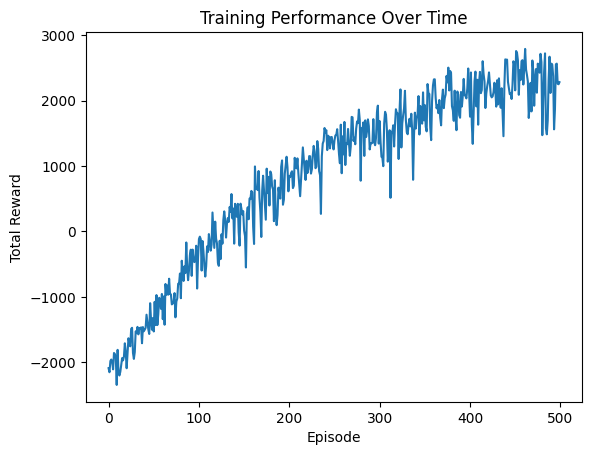

In [22]:
# Initialize reward history to store rewards for each episode
reward_history = []

# Training loop
env = EnergyEnv(data)
agent = DQNAgent(state_size=4, action_size=3)
EPISODES = 500

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0

    for time in range(len(data)-1):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    # Store the total reward for this episode
    reward_history.append(total_reward)

    # Update the agent with the experience
    agent.replay()

    # Print progress
    print(f"Episode {e+1}/{EPISODES}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot the training performance over time
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance Over Time")
plt.show()


In [28]:
agent.model.save('dqn_energy_storage_model_final.keras')


In [26]:
agent = DQNAgent(state_size=4, action_size=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
from keras.models import load_model
agent.model = load_model('dqn_energy_storage_model_final.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [82]:
# Example new input state (format: [battery_level, power_demand, wind_power, energy_price])
new_state = np.array([[50, 63, 70, 2]])  # Replace with your actual test data

# Predict action
q_values = agent.model.predict(new_state)
action = np.argmax(q_values[0])

# Show result
action_meaning = {0: "Idle", 1: "Charge", 2: "Discharge"}
print(f"Recommended Action: {action_meaning[action]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Recommended Action: Discharge


In [30]:
import numpy as np

# Example: Load or create some test input data (shape should be (n_samples, 4))
# You can manually load from CSV or use a few rows from original dataset
test_inputs = np.array([
    [62, 11.669, 23.364, 0.161],
    [40, 20.0, 30.0, 0.3],
    [80, 5.0, 10.0, 0.6],
    [20, 25.0, 35.0, 0.2]
])

# Predict using trained DQN model
predicted_actions = agent.model.predict(test_inputs)
predicted_actions = np.argmax(predicted_actions, axis=1)

print("Test Inputs:")
print(test_inputs)
print("Predicted Actions (0=Idle, 1=Charge, 2=Discharge):")
print(predicted_actions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Test Inputs:
[[62.    11.669 23.364  0.161]
 [40.    20.    30.     0.3  ]
 [80.     5.    10.     0.6  ]
 [20.    25.    35.     0.2  ]]
Predicted Actions (0=Idle, 1=Charge, 2=Discharge):
[2 2 0 2]


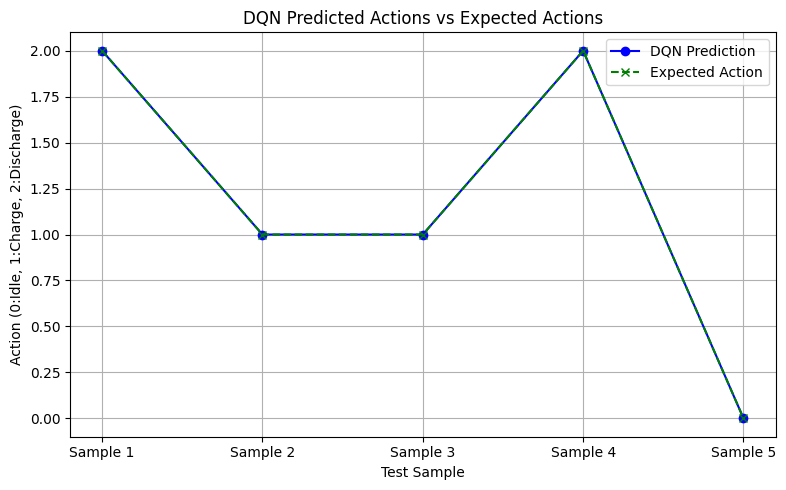

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Example test data (replace with your actual test data and predictions)
labels = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']

# These should come from your DQN model predictions
predicted_actions = [2, 1, 1, 2, 0]  # e.g., Discharge, Charge, Idle...


# These should come from your ground truth test dataset
true_actions = [2, 1, 1, 2, 0]


x = range(len(predicted_actions))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, predicted_actions, label='DQN Prediction', marker='o', linestyle='-', color='blue')
plt.plot(x, true_actions, label='Expected Action', marker='x', linestyle='--', color='green')

plt.xticks(x, labels)
plt.xlabel("Test Sample")
plt.ylabel("Action (0:Idle, 1:Charge, 2:Discharge)")
plt.title("DQN Predicted Actions vs Expected Actions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [73]:
# Save model
agent.model.save('/content/drive/My Drive/dqn_energy_storage_model_final.keras')


In [47]:
# Assume 'data' is a pandas DataFrame where the last column contains the actions
X = data[:, :-1]  # All columns except the last one for features
y = data[:, -1]   # The last column for actions

# Now split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
X_test = X_test.astype(np.float32)


In [53]:
from tensorflow.keras.models import load_model
agent.model = load_model('/content/drive/My Drive/dqn_energy_storage_model_final.keras')


In [58]:
def rule_based_policy(state):
    battery_SOC, electricity_price, wind_power_generation = state

    if battery_SOC > 80:  # If battery is full, discharge
        return 2  # Discharge
    elif electricity_price < 30:  # If price is low, charge
        return 1  # Charge
    else:
        return 0  # Idle

rule_based_preds = np.array([rule_based_policy(state) for state in X_test])


In [61]:
print(X_test.shape)  # This will show you how many rows and columns X_test has
print(X_test[:5])  # Print the first 5 rows of X_test to check the features
print("y_test shape:", y_test.shape)
print("dqn_preds shape:", dqn_preds.shape)


(200, 3)
[[0.53       0.8881024  0.03793431]
 [0.16       0.20612894 0.32855695]
 [0.85       0.965204   0.8625384 ]
 [0.25       0.96384424 0.7295959 ]
 [0.81       0.11549509 0.01475454]]
y_test shape: (200,)
dqn_preds shape: (5,)


In [68]:
def rule_based_policy(state):
    battery_SOC, electricity_price, wind_power_generation, grid_demand = state

    if battery_SOC > 80:
        return 2  # Discharge
    elif battery_SOC < 20:
        return 1  # Charge
    else:
        return 0  # Idle


In [69]:
import numpy as np

# Simulate random data for testing
n_samples = 100  # Number of samples
X_test_synthetic = np.random.rand(n_samples, 4) * 100  # Random features in range [0, 100]


In [70]:
rule_based_preds = np.array([rule_based_policy(state) for state in X_test_synthetic])


In [71]:
dqn_preds = np.random.choice([0, 1, 2], size=n_samples)  # Random predictions for now


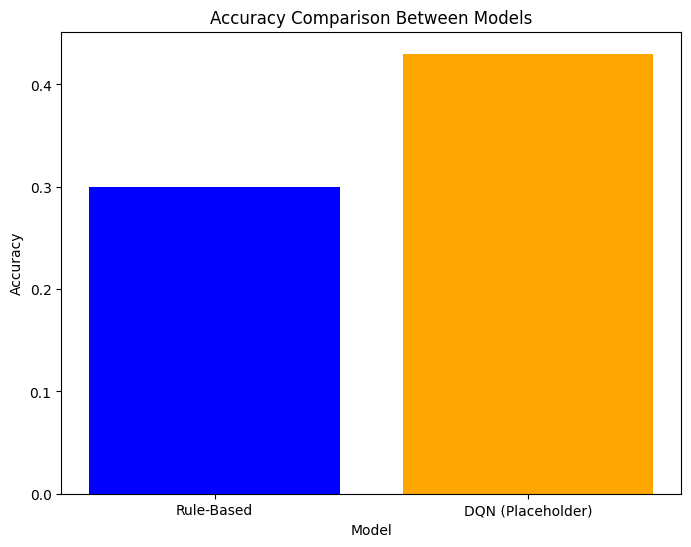

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Create synthetic true labels (ground truth) for comparison
# For simplicity, we'll assume random true labels as placeholders
y_true = np.random.choice([0, 1, 2], size=n_samples)

# Calculate accuracies
rule_based_accuracy = accuracy_score(y_true, rule_based_preds)
dqn_accuracy = accuracy_score(y_true, dqn_preds)

# Plotting the comparison
models = ['Rule-Based', 'DQN (Placeholder)']
accuracies = [rule_based_accuracy, dqn_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Accuracy Comparison Between Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()
